<a href="https://colab.research.google.com/github/seanan98/First/blob/master/hw4_0421.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/gdrive


# 数据导入

In [52]:
import numpy as np 
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/data/fer2013.csv')
num_of_instances = len(data) #获取数据集的数量
print("数据集的数量为：",num_of_instances)
pixels = data['pixels']
emotions = data['emotion']
usages = data['Usage']

数据集的数量为： 35887


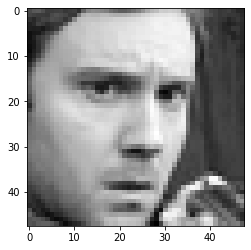

In [53]:
import cv2
img0 = list(map(eval,pixels[0].split(' ')))
np_img0 = np.asarray(img0)
img0 = np_img0.reshape(48,48)
import matplotlib.pyplot as plt
plt.imshow(img0, cmap="gray")
plt.show()

# 数据处理

In [54]:
emotions_Str=['anger','disgust','fear','happy','neutral','sad','surprised']

In [55]:
from keras.utils import to_categorical
from PIL import Image
import os

num_classes = 7   #表情的类别数目
x_train,y_train,x_val,y_val,x_test,y_test = [],[],[],[],[],[]
from tqdm import tqdm
for i in tqdm(range(num_of_instances)):
    usages_name = usages[i]
    emotions_Str_Nmae = emotions_Str[emotions[i]]
    one_hot_label = to_categorical(emotions[i],num_classes) #标签转换为one-hot编码，以满足keras对于数据的要求
    img = list(map(eval,pixels[i].split(' ')))
    np_img = np.asarray(img)
    img = np_img.reshape(48,48)
    if usages[i] == 'Training':
        x_train.append(img)
        y_train.append(one_hot_label)
    elif usages[i] == 'PrivateTest':
        x_val.append(img)
        y_val.append(one_hot_label)
    else:
        x_test.append(img)
        y_test.append(one_hot_label)
    subfolder = os.path.join('./',usages_name,emotions_Str_Nmae)
    if not os.path.exists(subfolder):
        os.makedirs(subfolder)
    im = Image.fromarray(np.uint8(img)).convert('L')
    im.save(os.path.join(subfolder , (str(i)+'.jpg') ))

100%|██████████| 35887/35887 [05:50<00:00, 102.50it/s]


In [56]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = x_train.reshape(-1,48,48,1)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = x_test.reshape(-1,48,48,1)
x_val = np.array(x_val).reshape(-1,48,48,1)
y_val = np.array(y_val)

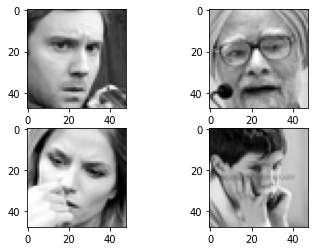

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(4): 
    plt.subplot(221+i)
    plt.gray()
    plt.imshow(x_train[i].reshape([48,48]))

In [58]:
x_train.shape

(28709, 48, 48, 1)

In [59]:
!nvidia-smi

Wed Apr 21 15:47:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    71W / 149W |   4397MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Baseline

## 模型搭建

In [60]:
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Activation, Dropout, Flatten, Dense, Input
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

input_shape = [48,48,1]
number_class = 7

model = Sequential()
# entry block
model.add(Input(shape=input_shape))
#model.add(layers.experimental.preprocessing.Rescaling(1.0/255))
# block 1
model.add(Conv2D(filters=32,kernel_size=3))
model.add(Conv2D(filters=32,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))
# block 2
model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))
# block 3
model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))
# Flatten
model.add(Flatten())
# 全连接层
#model.add(Dense(64,activation='softmax'))
model.add(Dense(number_class,activation='softmax'))

In [61]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 18, 18, 64)        36928     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 7, 7, 128)        

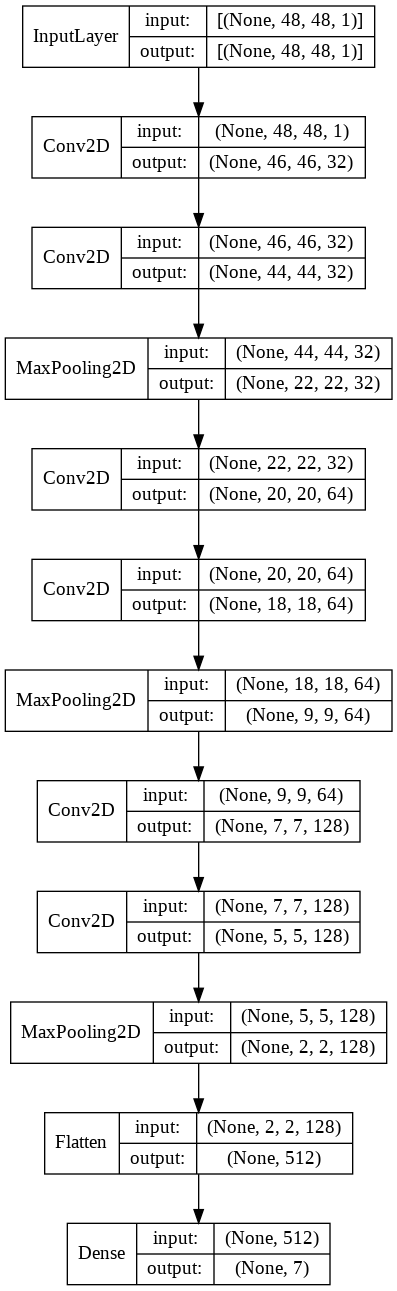

In [62]:
from keras.utils import plot_model 
plot_model(model,show_layer_names=False,to_file="baseline.png",show_shapes=True)

## 模型训练

In [63]:
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    "base_model.h5",
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True,
    verbose = 1
)
#进行训练
def model_train(model,batch_size,epochs,cb):
  model.compile(loss = 'categorical_crossentropy',optimizer = Adam(),metrics=['accuracy'])
  history = model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_val,y_val),callbacks=cb) 
  test_score = model.evaluate(x_test, y_test)
  return (history,test_score)

history_base, test_score_base = model_train(model,batch_size=512,epochs=20,cb=[model_checkpoint])

#batch_size = 512
#epochs = 20
#model.compile(loss = 'categorical_crossentropy',optimizer = Adam(),metrics=['accuracy'])
#history = model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_val,y_val))
#test_score = model.evaluate(x_test, y_test)

Epoch 1/20
57/57 [==============================] - 9s 146ms/step - loss: 3.7624 - accuracy: 0.2230 - val_loss: 1.7902 - val_accuracy: 0.2366

Epoch 00001: val_accuracy improved from -inf to 0.23656, saving model to base_model.h5
Epoch 2/20
57/57 [==============================] - 8s 140ms/step - loss: 1.7167 - accuracy: 0.3149 - val_loss: 1.6696 - val_accuracy: 0.3787

Epoch 00002: val_accuracy improved from 0.23656 to 0.37866, saving model to base_model.h5
Epoch 3/20
57/57 [==============================] - 8s 141ms/step - loss: 1.5758 - accuracy: 0.3943 - val_loss: 1.6073 - val_accuracy: 0.3681

Epoch 00003: val_accuracy did not improve from 0.37866
Epoch 4/20
57/57 [==============================] - 8s 141ms/step - loss: 1.5243 - accuracy: 0.4203 - val_loss: 1.4766 - val_accuracy: 0.4408

Epoch 00004: val_accuracy improved from 0.37866 to 0.44079, saving model to base_model.h5
Epoch 5/20
57/57 [==============================] - 8s 142ms/step - loss: 1.4212 - accuracy: 0.4667 - val_

## 模型评估

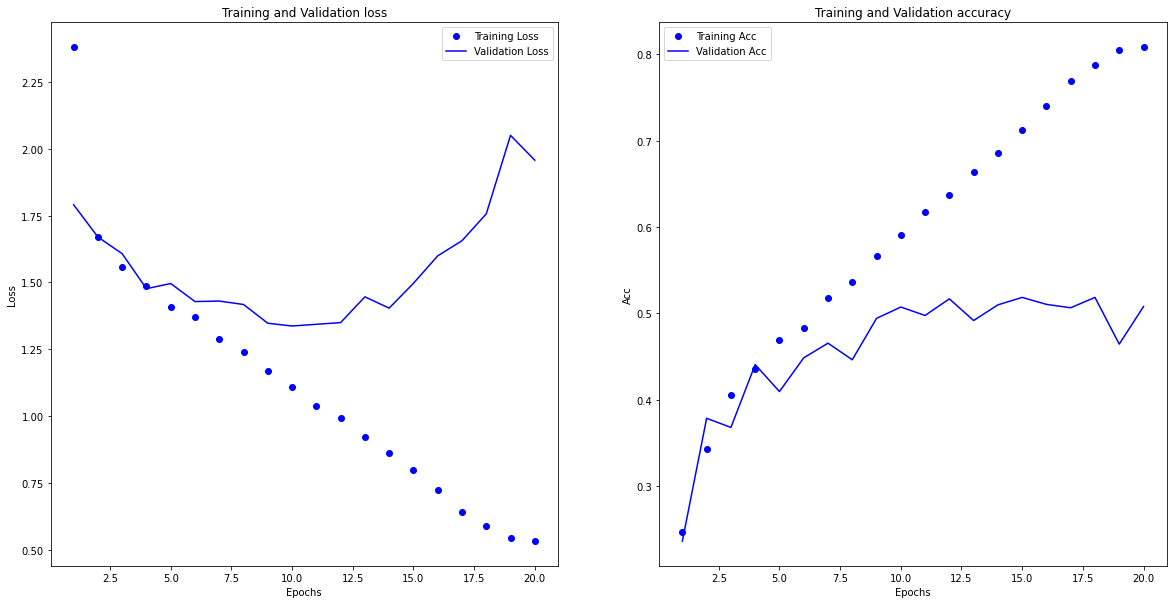

In [64]:
def model_eval(history,epochs):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs2 = range(1,epochs+1)
  fig = plt.figure(figsize=(20,10))
  ax = fig.add_subplot(121)
  ax.plot(epochs2,loss,'bo',label = 'Training Loss')
  ax.plot(epochs2,val_loss,'b',label='Validation Loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  ax2 = fig.add_subplot(122)
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  ax2.plot(epochs2,acc,'bo',label = 'Training Acc')
  ax2.plot(epochs2,val_acc,'b',label='Validation Acc')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Acc')
  plt.legend()
  plt.show()

model_eval(history = history_base,epochs=20)

可以明显的看到，越往后训练，训练集的准确率越高，验证集的准确率和损失函数反而越来越差，这是非常典型的过拟合的情形，有什么改进措施呢？

建议考虑以下改进方法（及其组合）：1）调整Block的数量；2）改变每个Block中的神经网络层数；3）改变每层的神经元数量及Kernel size的大小, 改变最大池化层的pool_size和strides；4）增加dropout；5）调整batch；6）调整epochs；7）其它任何你觉得可以改进模型准确性的方法

# 在Baseline模型基础上的改进


## 增加Rescaling 和 Dropout层, 减小batch size, 增大epoch, 并增加earlystopping，防止epochs过多导致过拟合

### 模型构建及训练

In [65]:
input_shape = [48,48,1]
number_class = 7

model1 = Sequential()
# entry block
model1.add(Input(shape=input_shape))
model1.add(layers.experimental.preprocessing.Rescaling(1.0/255))
# block 1
model1.add(Conv2D(filters=32,kernel_size=3))
model1.add(Conv2D(filters=32,kernel_size=3,activation='relu'))
model1.add(MaxPool2D(pool_size=2,strides=2))
# block 2
model1.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model1.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model1.add(MaxPool2D(pool_size=2,strides=2))
# block 3
model1.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model1.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model1.add(MaxPool2D(pool_size=2,strides=2))
# Flatten
model1.add(Flatten())
## dropout
model1.add(Dropout(rate=0.5))
model1.add(Dense(number_class,activation='softmax'))

In [66]:
model1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 18, 18, 64)        36928     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 9, 9, 64)         

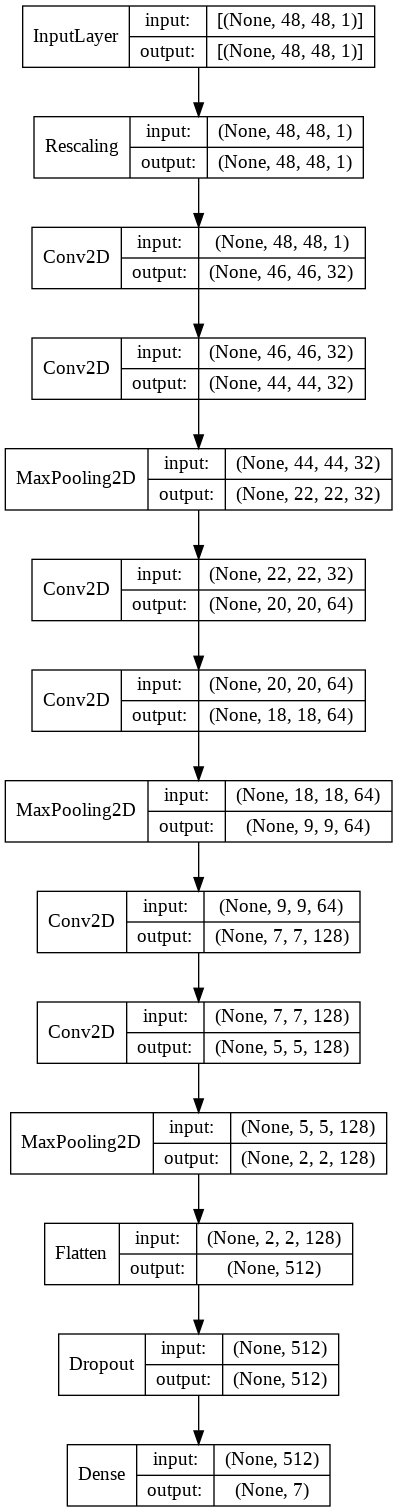

In [67]:
from keras.utils import plot_model 
plot_model(model1,show_layer_names=False,to_file="baseline1.png",show_shapes=True)

In [68]:
from keras.callbacks import EarlyStopping 
es = EarlyStopping(monitor="val_loss",mode="min",patience=10)
model1_checkpoint = ModelCheckpoint(
    "base_model1.h5",
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True,
    verbose = 1
)

In [69]:
#进行训练
history_base1, test_score_base1 = model_train(model1,batch_size=128,epochs=50,cb=[model1_checkpoint,es])

#batch_size = 128
#epochs = 50
#model1.compile(loss = 'categorical_crossentropy',optimizer = Adam(),metrics=['accuracy'])
#history1 = model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_val,y_val))
#test_score1 = model.evaluate(x_test, y_test)

Epoch 1/50
225/225 [==============================] - 10s 42ms/step - loss: 1.8377 - accuracy: 0.2364 - val_loss: 1.7412 - val_accuracy: 0.2901

Epoch 00001: val_accuracy improved from -inf to 0.29005, saving model to base_model1.h5
Epoch 2/50
225/225 [==============================] - 9s 41ms/step - loss: 1.6455 - accuracy: 0.3489 - val_loss: 1.4203 - val_accuracy: 0.4480

Epoch 00002: val_accuracy improved from 0.29005 to 0.44804, saving model to base_model1.h5
Epoch 3/50
225/225 [==============================] - 9s 41ms/step - loss: 1.4147 - accuracy: 0.4575 - val_loss: 1.3267 - val_accuracy: 0.4865

Epoch 00003: val_accuracy improved from 0.44804 to 0.48649, saving model to base_model1.h5
Epoch 4/50
225/225 [==============================] - 9s 41ms/step - loss: 1.3176 - accuracy: 0.5003 - val_loss: 1.2481 - val_accuracy: 0.5146

Epoch 00004: val_accuracy improved from 0.48649 to 0.51463, saving model to base_model1.h5
Epoch 5/50
225/225 [==============================] - 9s 42ms/

### 模型评估

In [70]:
#model_eval(history_base1,epochs=50)

In [71]:
from keras.models import load_model 
saved_base_model = load_model("base_model.h5")
_, base_model_test_acc = saved_base_model.evaluate(x_test,y_test)
saved_base_model1 = load_model("base_model1.h5")
_, base_model1_test_acc = saved_base_model1.evaluate(x_test,y_test)

113/113 [==============================] - 1s 7ms/step - loss: 1.2075 - accuracy: 0.5921


In [72]:
print("baseline model test accuracy:",base_model_test_acc)
print("Modified baseline model test accuracy:",base_model1_test_acc)

baseline model test accuracy: 0.5243800282478333
Modified baseline model test accuracy: 0.592086911201477


可以发现，修改后的模型在baseline模型的基础上有了一些改进！下面，我们继续调整模型参数。

## 更改卷积层和池化层的参数

### 模型构建及训练

In [73]:
input_shape = [48,48,1]
number_class = 7

model2 = Sequential()
# entry block
model2.add(Input(shape=input_shape))
model2.add(layers.experimental.preprocessing.Rescaling(1.0/255))
# block 1
model2.add(Conv2D(filters=32,kernel_size=5,strides=1,padding='same',activation='relu'))
model2.add(MaxPool2D(pool_size=3,strides=2))
# block 2
model2.add(Conv2D(filters=32,kernel_size=4,strides=1,activation='relu'))
model2.add(MaxPool2D(pool_size=3,strides=2))
# block 3
model2.add(Conv2D(filters=64,kernel_size=5,strides=1,padding='same',activation='relu'))
model2.add(MaxPool2D(pool_size=3,strides=2))
# Flatten
model2.add(Flatten())
## dropout
model2.add(Dense(2048,activation='relu'))
model2.add(Dropout(rate=0.4))
model2.add(Dense(1024,activation='relu'))
model2.add(Dropout(rate=0.4))
model2.add(Dense(number_class,activation='softmax'))

In [74]:
model2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 48, 48, 32)        832       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 20, 20, 32)        16416     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 9, 9, 64)          51264     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 4, 4, 64)         

In [75]:
#进行训练
es = EarlyStopping(monitor="val_loss",mode="min",patience=10)
model2_checkpoint = ModelCheckpoint(
    "base_model2.h5",
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True,
    verbose = 1
)
history_base2, test_score_base2 = model_train(model2,batch_size=128,epochs=50,cb=[model2_checkpoint,es])

Epoch 1/50
225/225 [==============================] - 6s 22ms/step - loss: 1.8086 - accuracy: 0.2484 - val_loss: 1.5370 - val_accuracy: 0.4001

Epoch 00001: val_accuracy improved from -inf to 0.40011, saving model to base_model2.h5
Epoch 2/50
225/225 [==============================] - 5s 21ms/step - loss: 1.5127 - accuracy: 0.4128 - val_loss: 1.3877 - val_accuracy: 0.4684

Epoch 00002: val_accuracy improved from 0.40011 to 0.46838, saving model to base_model2.h5
Epoch 3/50
225/225 [==============================] - 5s 21ms/step - loss: 1.3536 - accuracy: 0.4747 - val_loss: 1.2963 - val_accuracy: 0.5124

Epoch 00003: val_accuracy improved from 0.46838 to 0.51240, saving model to base_model2.h5
Epoch 4/50
225/225 [==============================] - 5s 21ms/step - loss: 1.2370 - accuracy: 0.5285 - val_loss: 1.2478 - val_accuracy: 0.5208

Epoch 00004: val_accuracy improved from 0.51240 to 0.52076, saving model to base_model2.h5
Epoch 5/50
225/225 [==============================] - 5s 21ms/s

In [76]:
#model_eval(history_base2,epochs=18)

In [77]:
saved_base_model2 = load_model("base_model2.h5")
_, base_model2_test_acc = saved_base_model2.evaluate(x_test,y_test)

113/113 [==============================] - 1s 5ms/step - loss: 1.3732 - accuracy: 0.5740


In [78]:
print("baseline model test accuracy:",base_model_test_acc)
print("Modified baseline model version 1 test accuracy:",base_model1_test_acc)
print("Modified baseline model version 2 test accuracy:",base_model2_test_acc)

baseline model test accuracy: 0.5243800282478333
Modified baseline model version 1 test accuracy: 0.592086911201477
Modified baseline model version 2 test accuracy: 0.5739760398864746


可以发现，这样调整后并没有使模型在测试集上的表现更好，所以我们选择version 1. 并在其基础上继续改进。

## 数据增强

In [79]:
from keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomTranslation

In [80]:
input_shape = [48,48,1]
number_class = 7

model1_1 = Sequential()
# entry block
model1_1.add(Input(shape=input_shape))
model1_1.add(layers.experimental.preprocessing.Rescaling(1.0/255))
# data argumentation 
model1_1.add(RandomFlip())
model1_1.add(RandomRotation((-0.2, 0.3)))

# block 1
model1_1.add(Conv2D(filters=32,kernel_size=3))
model1_1.add(Conv2D(filters=32,kernel_size=3,activation='relu'))
model1_1.add(MaxPool2D(pool_size=2,strides=2))
# block 2
model1_1.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model1_1.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model1_1.add(MaxPool2D(pool_size=2,strides=2))
# block 3
model1_1.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model1_1.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model1_1.add(MaxPool2D(pool_size=2,strides=2))
# Flatten
model1_1.add(Flatten())
## dropout
model1_1.add(Dropout(rate=0.5))
model1_1.add(Dense(number_class,activation='softmax'))

In [81]:
model1_1.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_7 (Rescaling)      (None, 48, 48, 1)         0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, 48, 48, 1)         0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 20, 20, 64)      

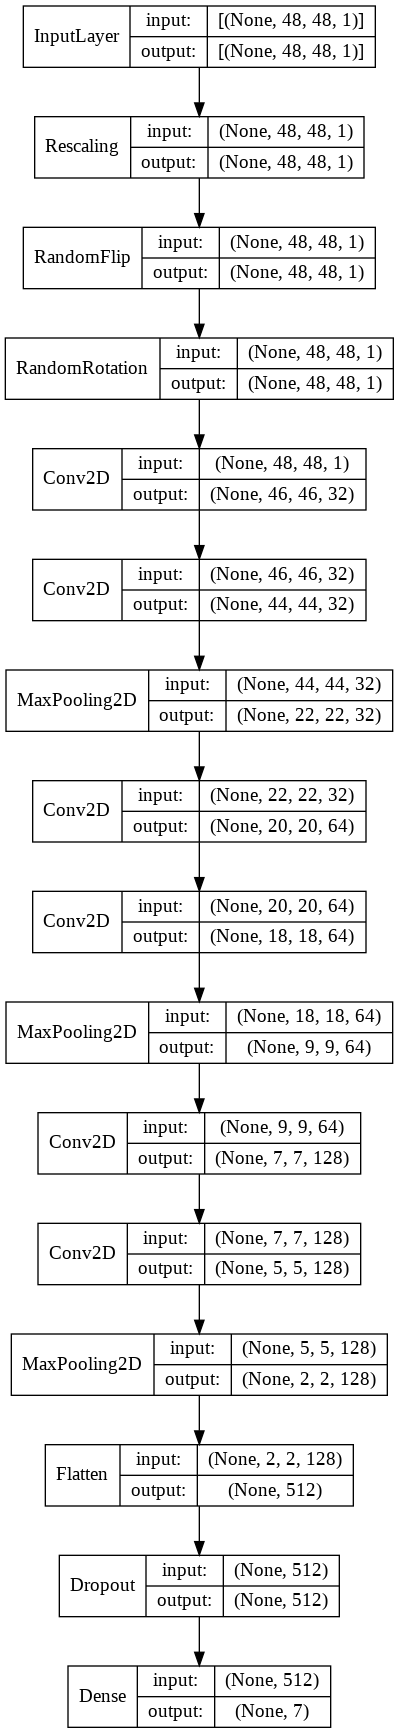

In [82]:
from keras.utils import plot_model 
plot_model(model1_1,show_layer_names=False,to_file="baseline1_1.png",show_shapes=True)

In [83]:
from keras.callbacks import EarlyStopping 
es = EarlyStopping(monitor="val_loss",mode="min",patience=10)
model1_1_checkpoint = ModelCheckpoint(
    "base_model1_1.h5",
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True,
    verbose = 1
)
#进行训练
history_base1_1, test_score_base1_1 = model_train(model1_1,batch_size=128,epochs=50,cb=[model1_1_checkpoint,es])

Epoch 1/50
225/225 [==============================] - 11s 43ms/step - loss: 1.8415 - accuracy: 0.2289 - val_loss: 1.7952 - val_accuracy: 0.2519

Epoch 00001: val_accuracy improved from -inf to 0.25188, saving model to base_model1_1.h5
Epoch 2/50
225/225 [==============================] - 10s 43ms/step - loss: 1.7959 - accuracy: 0.2617 - val_loss: 1.7895 - val_accuracy: 0.2547

Epoch 00002: val_accuracy improved from 0.25188 to 0.25467, saving model to base_model1_1.h5
Epoch 3/50
225/225 [==============================] - 10s 43ms/step - loss: 1.7930 - accuracy: 0.2555 - val_loss: 1.7860 - val_accuracy: 0.2483

Epoch 00003: val_accuracy did not improve from 0.25467
Epoch 4/50
225/225 [==============================] - 10s 43ms/step - loss: 1.7782 - accuracy: 0.2640 - val_loss: 1.7638 - val_accuracy: 0.2717

Epoch 00004: val_accuracy improved from 0.25467 to 0.27166, saving model to base_model1_1.h5
Epoch 5/50
225/225 [==============================] - 10s 43ms/step - loss: 1.7614 - accu

In [84]:
saved_base_model1_1 = load_model("base_model1_1.h5")
_, base_model1_1_test_acc = saved_base_model1_1.evaluate(x_test,y_test)
print("baseline model test accuracy:",base_model_test_acc)
print("Modified baseline model version 1 test accuracy:",base_model1_test_acc)
print("Modified baseline model version 1_1 test accuracy:",base_model1_1_test_acc)

113/113 [==============================] - 1s 6ms/step - loss: 1.2186 - accuracy: 0.5386
baseline model test accuracy: 0.5243800282478333
Modified baseline model version 1 test accuracy: 0.592086911201477
Modified baseline model version 1_1 test accuracy: 0.538590133190155


In [84]:
from google.colab import files 
#files.download("/content/")

# 使用预训练的ResNet